In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sys

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils import plot_pairplot, calculate_stats, correlation_with_target, feature_relevance_manual_mi, grid_search_random_forest
from preprocessing import handle_missing_values, one_hot_encoding, normalize_df
from data_splitting import train_validate_split
from models import LogisticRegression, LDA, DecisionTree, RandomForest
from metrics import plot_conf_matrix, accuracy, precision, recall, f1_score, plot_pr_curve, plot_roc_curve
from balancing import undersampling, oversampling, smote

RANDOM_STATE = 42
TARGET = 'war_class'

TRUE_INTERVALS = {
    'raptor_total': (-16, 12),
    # 'war_total': (-6, 24),
    'pace_impact': (-2, 3),
    'mp': (0, float('inf')),
    'poss': (0, float('inf')),
}

# Load the dataset
WAR_class_dev = pd.read_csv('../data/raw/WAR_class_dev.csv')

WAR_class_dev = WAR_class_dev.drop(columns=['war_total'])

WAR_class_dev.head()

,poss,mp,raptor_total,pace_impact,war_class
0,2283.468774,826.890427,-3.369325,0.472195,2
1,1185.081598,567.265296,-5.389056,1.567405,2
2,5272.362761,2403.044668,7.084319,-0.534305,3
3,7594.083790,3709.114977,5.532538,-0.710111,3
4,8479.653469,3803.026613,5.089253,-0.699135,3


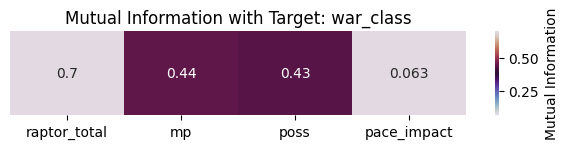

In [6]:
_ = feature_relevance_manual_mi(WAR_class_dev, TARGET)

In [7]:
WAR_class_dev_cleaned = handle_missing_values(WAR_class_dev, true_intervals=TRUE_INTERVALS)

WAR_class_dev_cleaned.head()

,poss,mp,raptor_total,pace_impact,war_class
0,2283.468774,826.890427,-3.369325,0.472195,2
1,1185.081598,567.265296,-5.389056,1.567405,2
2,5272.362761,2403.044668,7.084319,-0.534305,3
3,7594.083790,3709.114977,5.532538,-0.710111,3
4,8479.653469,3803.026613,5.089253,-0.699135,3


In [8]:
# split the data into train and validation sets

WAR_class_train, WAR_class_val = train_validate_split(WAR_class_dev, random_state=RANDOM_STATE)
WAR_class_train_cleaned = handle_missing_values(WAR_class_train, true_intervals=TRUE_INTERVALS)
WAR_class_train_cleaned_normalized, normalized_train_stats = normalize_df(WAR_class_train_cleaned)

train_stats = calculate_stats(WAR_class_train_cleaned)

WAR_class_val_cleaned = handle_missing_values(WAR_class_val, true_intervals=TRUE_INTERVALS, train=False, stats=train_stats, reference_df=WAR_class_train_cleaned)
WAR_class_val_cleaned_normalized, _ = normalize_df(WAR_class_val_cleaned, train=False, stats=normalized_train_stats)

In [9]:
X_train = WAR_class_train_cleaned_normalized.drop(columns=[TARGET])
y_train = WAR_class_train_cleaned_normalized[TARGET]

X_val = WAR_class_val_cleaned_normalized.drop(columns=[TARGET])
y_val = WAR_class_val_cleaned_normalized[TARGET]

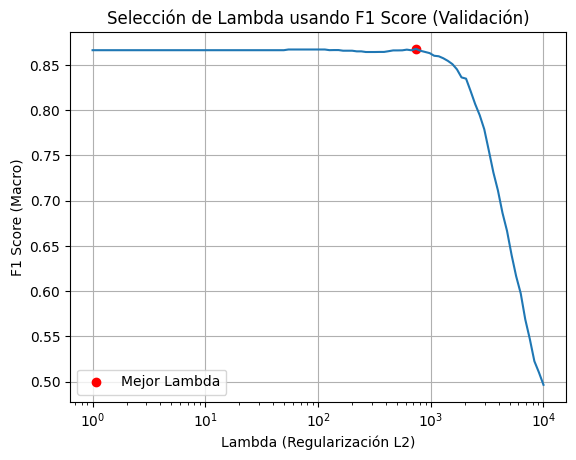

Mejor modelo encontrado con λ = 739.07220 (F1 Score = 0.8678)
Accuracy: 0.8680
Precision: 0.8769
Recall: 0.8797
F1 Score: 0.8678


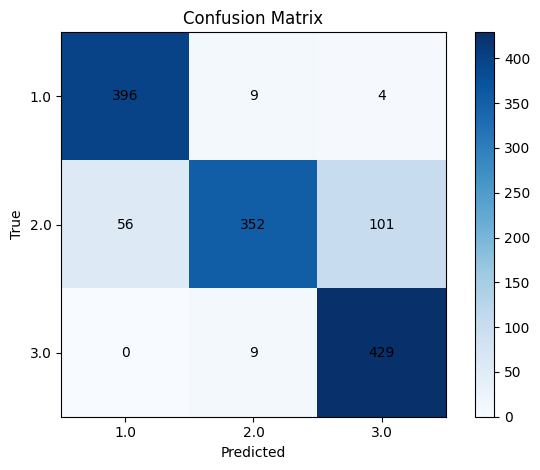

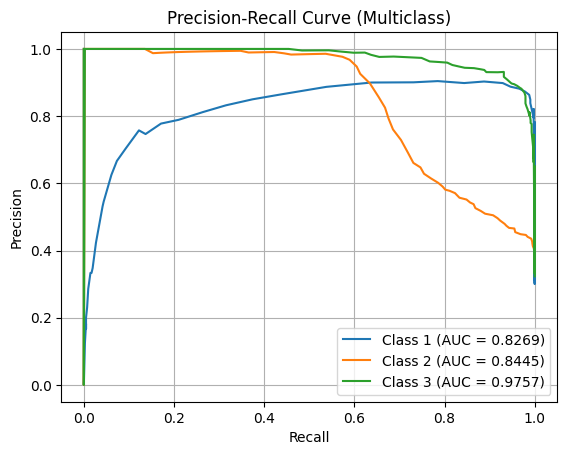

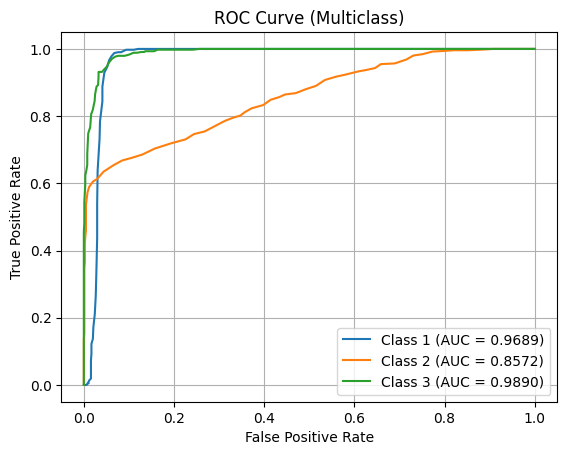

In [10]:
# train with logistic regression
log_reg = LogisticRegression(multi_class='multinomial')

# Definir rango de lambda
lambdas = np.logspace(0, 4, 100)
f1_scores = []

best_f1 = -1
best_model = None
best_lambda = None

for l2 in lambdas:
    log_reg = LogisticRegression(multi_class='multinomial', l2=l2)
    log_reg.fit(X_train, y_train)

    y_val_pred_lr_lambdas = log_reg.predict(X_val)
    f1 = f1_score(y_val, y_val_pred_lr_lambdas)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_lambda = l2
        best_model = log_reg

# Graficar F1 Score vs Lambda
plt.figure()
plt.plot(lambdas, f1_scores)
plt.scatter(best_lambda, best_f1, color='red', label='Mejor Lambda')
plt.xscale('log')
plt.xlabel("Lambda (Regularización L2)")
plt.ylabel("F1 Score (Macro)")
plt.title("Selección de Lambda usando F1 Score (Validación)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor modelo encontrado con λ = {best_lambda:.5f} (F1 Score = {best_f1:.4f})")

# Evaluar mejor modelo
y_val_pred_lr = best_model.predict(X_val)
y_val_pred_proba_lr = best_model.predict_proba(X_val)

accuracy_score = accuracy(y_val, y_val_pred_lr)
precision_score = precision(y_val, y_val_pred_lr)
recall_score = recall(y_val, y_val_pred_lr)
f1_score_value = f1_score(y_val, y_val_pred_lr)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_val, y_val_pred_lr)
_ = plot_pr_curve(y_val, y_val_pred_proba_lr)
_ = plot_roc_curve(y_val, y_val_pred_proba_lr)



Accuracy: 0.8827
Precision: 0.8939
Recall: 0.8956
F1 Score: 0.8814


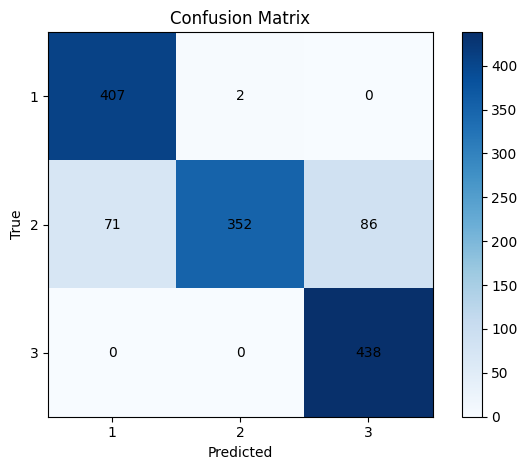

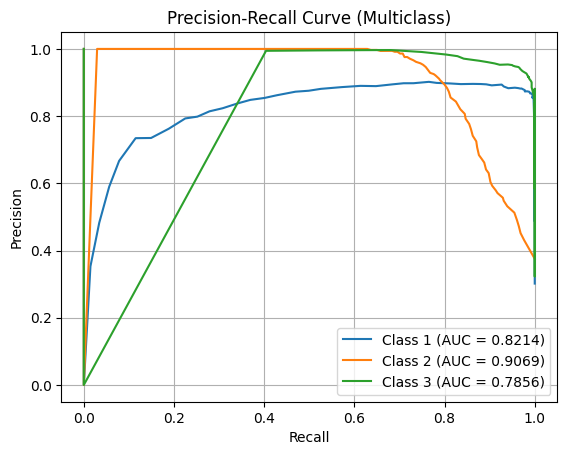

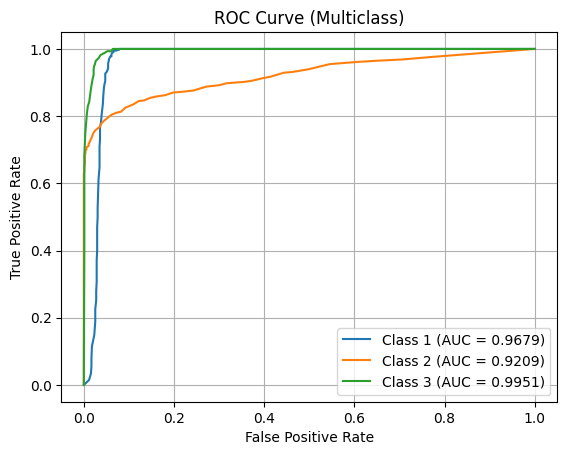

In [11]:
# do the same for LDA
lda = LDA()

lda.fit(X_train, y_train)

y_val_pred_lda = lda.predict(X_val)
y_val_pred_proba_lda = lda.predict_proba(X_val)

accuracy_score = accuracy(y_val, y_val_pred_lda)
precision_score = precision(y_val, y_val_pred_lda)
recall_score = recall(y_val, y_val_pred_lda)
f1_score_value = f1_score(y_val, y_val_pred_lda)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_val, y_val_pred_lda)
_ = plot_pr_curve(y_val, y_val_pred_proba_lda)
_ = plot_roc_curve(y_val, y_val_pred_proba_lda)



In [12]:
# do the same for random forest
rf = RandomForest()

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
y_val_pred_proba_rf = rf.predict_proba(X_val)


Árboles: 100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Accuracy: 0.9528
Precision: 0.9527
Recall: 0.9555
F1 Score: 0.9538


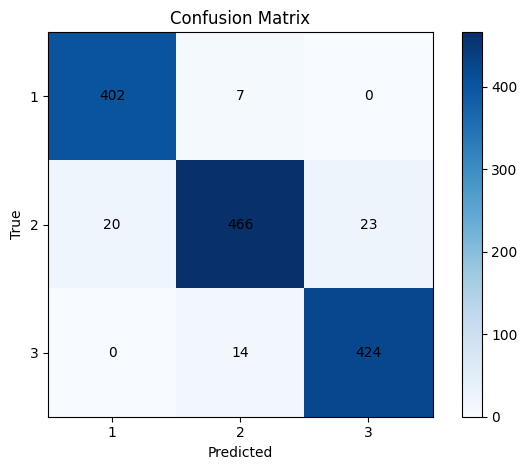

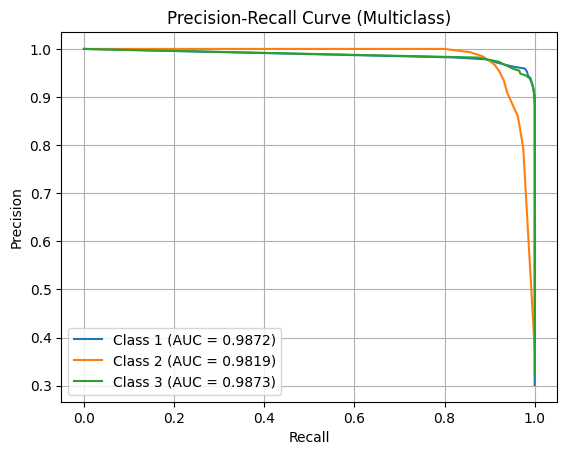

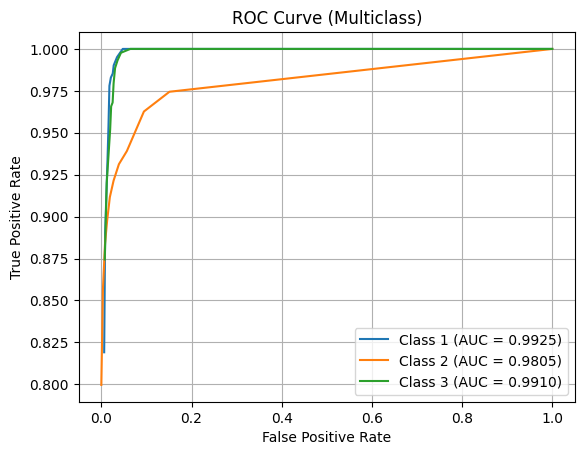

In [13]:
accuracy_score = accuracy(y_val, y_val_pred_rf)
precision_score = precision(y_val, y_val_pred_rf)
recall_score = recall(y_val, y_val_pred_rf)
f1_score_value = f1_score(y_val, y_val_pred_rf)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_val, y_val_pred_rf)
_ = plot_pr_curve(y_val, y_val_pred_proba_rf)
_ = plot_roc_curve(y_val, y_val_pred_proba_rf)

In [ ]:
# use grid search to find the best hyperparameters for random forest

param_grid = {
    'n_trees': [10, 25, 50, 75],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 10]
}

best_params, best_score, best_model = grid_search_random_forest(X_train, y_train, X_val, y_val, param_grid)

print("Best parameters:", best_params)
print("Best score:", best_score)

Grid Search: 100%|██████████| 12/12 [05:40<00:00, 28.35s/it]

Best parameters: {'n_trees': 10, 'max_depth': None, 'min_samples_split': 4}
Best score: 0.9544592391291356


In [15]:
# train the model and evaluate them in test set

# Load the test set
WAR_class_test = pd.read_csv('../data/raw/WAR_class_test.csv')
WAR_class_test = WAR_class_test.drop(columns=['war_total'])

dev_stats = calculate_stats(WAR_class_dev)
WAR_class_test_cleaned = handle_missing_values(WAR_class_test, true_intervals=TRUE_INTERVALS, train=False, stats=dev_stats, reference_df=WAR_class_dev_cleaned)

WAR_class_dev_cleaned_normalized, normalized_dev_stats = normalize_df(WAR_class_dev_cleaned)
WAR_class_test_cleaned_normalized, _ = normalize_df(WAR_class_test_cleaned, train=False, stats=normalized_dev_stats)

X_test = WAR_class_test_cleaned_normalized.drop(columns=[TARGET])
y_test = WAR_class_test_cleaned_normalized[TARGET]

X_dev = WAR_class_dev_cleaned_normalized.drop(columns=[TARGET])
y_dev = WAR_class_dev_cleaned_normalized[TARGET]

Accuracy: 0.8850
Precision: 0.8882
Recall: 0.8934
F1 Score: 0.8852


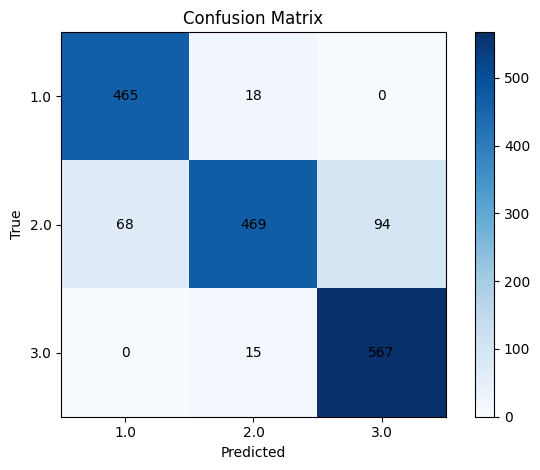

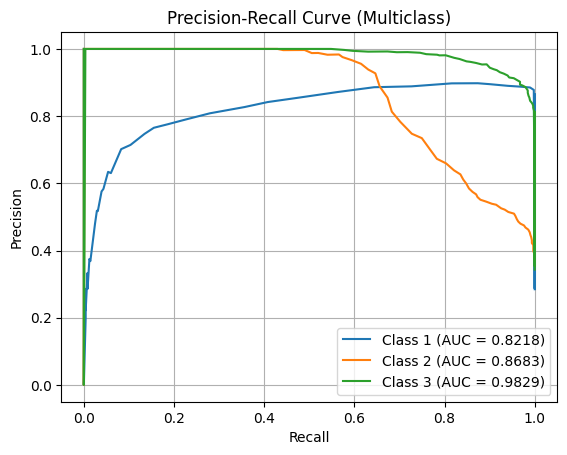

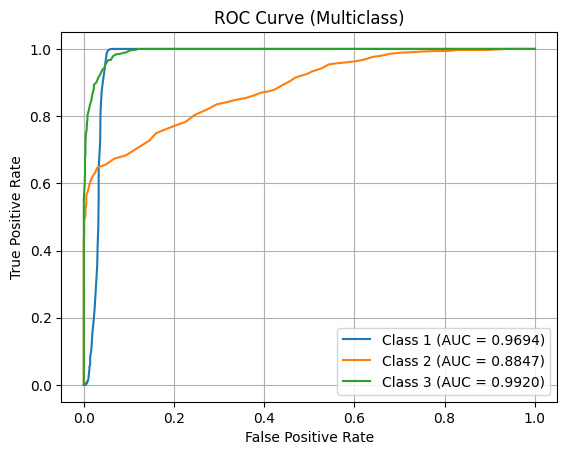

In [16]:
# logistic regression
log_reg = LogisticRegression(multi_class='multinomial', l2=best_lambda)
log_reg.fit(X_dev, y_dev)

y_test_pred_lr = log_reg.predict(X_test)
y_test_pred_proba_lr = log_reg.predict_proba(X_test)

accuracy_score = accuracy(y_test, y_test_pred_lr)
precision_score = precision(y_test, y_test_pred_lr)
recall_score = recall(y_test, y_test_pred_lr)
f1_score_value = f1_score(y_test, y_test_pred_lr)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_test, y_test_pred_lr)
_ = plot_pr_curve(y_test, y_test_pred_proba_lr)
_ = plot_roc_curve(y_test, y_test_pred_proba_lr)

Accuracy: 0.9057
Precision: 0.9114
Recall: 0.9150
F1 Score: 0.9047


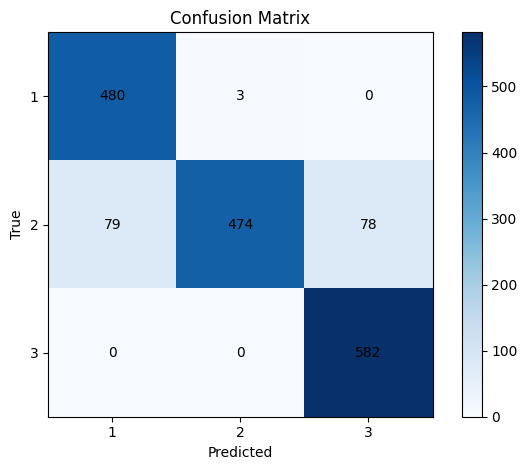

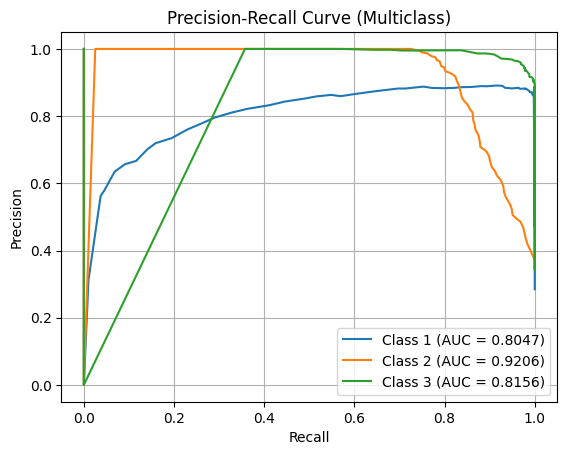

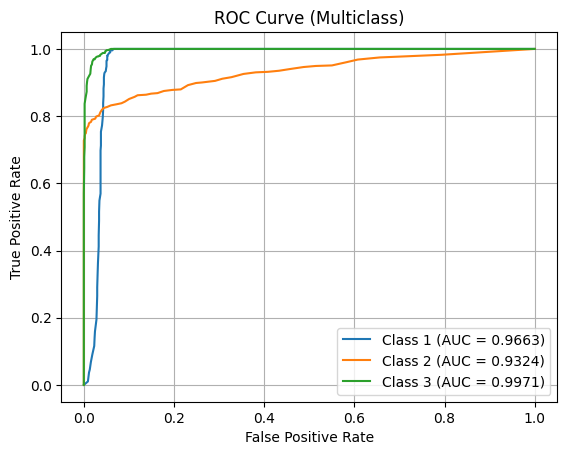

In [17]:
# LDA
lda = LDA()

lda.fit(X_dev, y_dev)

y_test_pred_lda = lda.predict(X_test)
y_test_pred_proba_lda = lda.predict_proba(X_test)

accuracy_score = accuracy(y_test, y_test_pred_lda)
precision_score = precision(y_test, y_test_pred_lda)
recall_score = recall(y_test, y_test_pred_lda)
f1_score_value = f1_score(y_test, y_test_pred_lda)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_test, y_test_pred_lda)
_ = plot_pr_curve(y_test, y_test_pred_proba_lda)
_ = plot_roc_curve(y_test, y_test_pred_proba_lda)

Árboles: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]

Accuracy: 0.9558
Precision: 0.9554
Recall: 0.9586
F1 Score: 0.9567


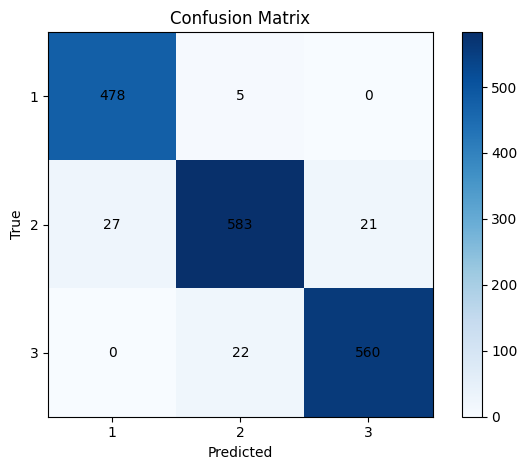

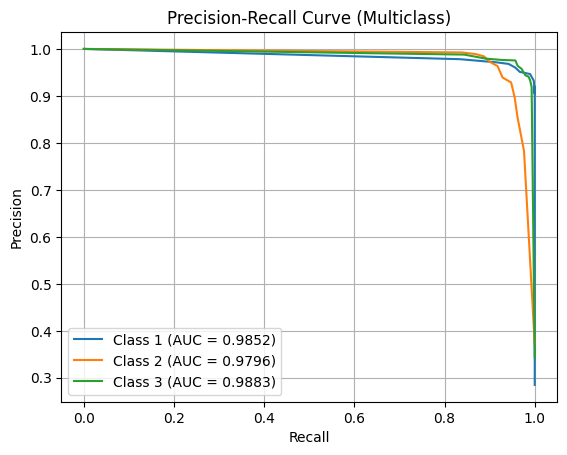

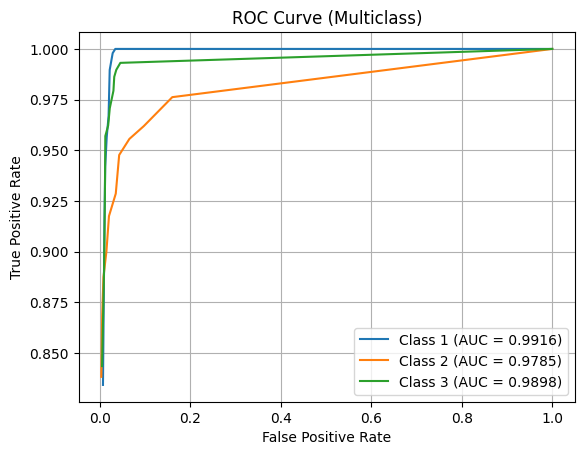

In [18]:
# random forest
rf = RandomForest()

rf.fit(X_dev, y_dev)

y_test_pred_rf = rf.predict(X_test)
y_test_pred_proba_rf = rf.predict_proba(X_test)

accuracy_score = accuracy(y_test, y_test_pred_rf)
precision_score = precision(y_test, y_test_pred_rf)
recall_score = recall(y_test, y_test_pred_rf)
f1_score_value = f1_score(y_test, y_test_pred_rf)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score_value:.4f}")

plot_conf_matrix(y_test, y_test_pred_rf)
_ = plot_pr_curve(y_test, y_test_pred_proba_rf)
_ = plot_roc_curve(y_test, y_test_pred_proba_rf)